In [1]:
import os
import cv2
import math
import time
import numpy as np
from skimage import io, color
from scipy.spatial import distance
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from utility_funcitions import *

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.4f}".format

##### Load test image with noise

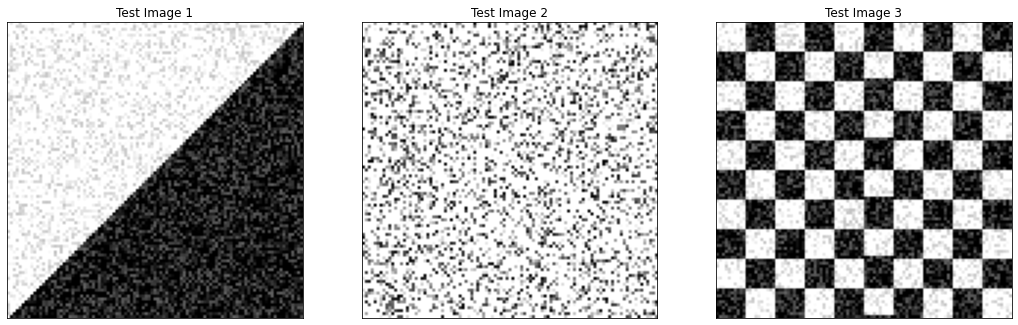

In [3]:
# Load the test images
pictures_dir = r'C:\Users\carot\Downloads\DISIP\pictures'

test_1 = load_image(pictures_dir+r'\test_1.jpg')
test_2 = load_image(pictures_dir+r'\test_2.jpg')
test_3 = load_image(pictures_dir+r'\test_3.jpg')

# Add noise
test_1n = random_noise(test_1, -60, +100)
test_2n = random_noise(test_2, -40, +80)
test_3n = random_noise(test_3, -60, +100)

# Show the images with noise
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,10))
ax1.set_title("Test Image 1")
ax1.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax1.imshow(test_1n, cmap='gray')
ax2.set_title("Test Image 2")
ax2.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax2.imshow(test_2n, cmap='gray')
ax3.set_title("Test Image 3")
ax3.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax3.imshow(test_3n, cmap='gray')

<h1><center>Bilateral Filtering</center></h1>

The main properties of **Bilateral Filtering** is that it does not do averaging across edges. That is why it is also called edge preserving filter

In  Gaussian filter only nearby pixels are considered while filtering. It doesn't consider whether pixels have almost the same intensity. It doesn't consider whether a pixel is an edge pixel or not. So it blurs the edges also, which we don't want to do.

Bilateral filtering also takes a Gaussian filter in space, but one more Gaussian filter which is a function of pixel difference. The Gaussian function of space makes sure that only nearby pixels are considered for blurring, while the Gaussian function of intensity difference makes sure that only those pixels with similar intensities to the central pixel are considered for blurring. So it preserves the edges **since pixels at edges will have large intensity variation**.


The important point which is considered in Bilateral filtering is that the two pixels close to each other not only if they occupy nearby spatial locations but also if they have some similarity in the photometric range. This properties of bilateral filtering overcome the drawback of other filter and able to preserve edges.

<b>Image filtered:</b>

\begin{equation}
\large
I^{filtered}(x)=\frac{1}{W_p}\sum_{x_i\in\,\Omega} I(x_i)\,c(x_i,x)\,s\big({I(x_i),I(x)}\big)
\end{equation}

and normalization term, $W_{p}$ is defined as 

\begin{equation}
\large
W_p=\sum_{x_i\in\,\Omega} c(x_i,x)\,s\big({I(x_i),I(x)}\big)
\end{equation}
where
<ul>
  <li>$I^{filtered}$ is the filtered image</li>
  <li>$I$ is the original input image to be filtered</li>
  <li>$x$ are the coordinates of the current pixel to be filtered</li>
  <li>$\Omega$ is the window centered in $x$</li>
  <li>$x_i$ is a pixel in $\Omega$</li>
  <li>$C$ is the <i>Closeness function</i> for smoothing differences in coordinates </li>
  <li>$S$ is the <i>Similarity function</i> for smoothing differences in intensities </li>
</ul> 

___

A simple and important case of Bilateral Filtering is <u>shift-invariant Gaussian filtering</u>, in which both the <i>Closeness function</i> $c\,(\xi,\textbf X)$ and the <i>Similarity function</i> $s\,(\phi,\textbf f)$ are Gaussian functions of the Euclidean distance between their arguments
<h3><center>Closeness function:</center></h3>

\begin{equation}
\large
c\,(\xi,\textbf X)=e^{-\frac{1}{2}{\left(\frac{d(\xi,\,X)}{\sigma d}\right)}^2}
\end{equation}
where
 <ul>
  <li>$d(\xi,\,X)$ is the Euclidian distance between $\xi$ and $X$ </li>
</ul> 


<h3><center>Similarity function:</center></h3>

\begin{equation}
\large
s\,(\phi,\textbf f)=e^{-\frac{1}{2}{\left(\frac{\delta(f(\xi),\,f(x))}{\sigma r}\right)}^2}
\end{equation}
where
 <ul>
  <li>$\delta(\phi,\textbf{f})=\delta(\phi-\textbf{f})=\|\phi-\textbf{f}\|$ is a measure of distance between the two intensity
values $\phi$ and $\textbf{f}$</li>
</ul> 

In [2]:
# Closeness function
def c(xi, X, sigma_d):
    d = distance.euclidean(xi, X)
    return np.exp((-0.5)*((d**2/sigma_d**2)))

# Similarity function
def s(phi, F, sigma_r, gray_img):
    if not gray_img:   # List value
        delta = distance.euclidean(phi, F)
    else:              # Scalar value
        delta = abs(phi - F)
    return np.exp((-0.5)*((delta**2/sigma_r**2)))

In [3]:
# The spatial (or domain) kernel for smoothing differences in coordinates
def spatial_kernel(size, sigma):
    gaussian_kernel = np.empty((size,size))
    c_x = c_y = int(size/2)

    for i in range(size):
        for j in range(size):
            d = distance.euclidean([j, i], [c_x, c_y])
            gaussian_kernel[j, i] = np.exp((-0.5)*((d**2/sigma**2)))
    return gaussian_kernel

def similatiry_matrix(center_value, window_values, sigma_r, gray_img):
    center_matrix = np.full(window_values.shape, center_value)
    
    if gray_img:
        d_matrix = np.absolute(window_values-center_matrix)
    else:
        d_matrix = np.linalg.norm(window_values-center_matrix, axis=2)
    
    return np.exp((-0.5)*((d_matrix**2/sigma_r**2)))

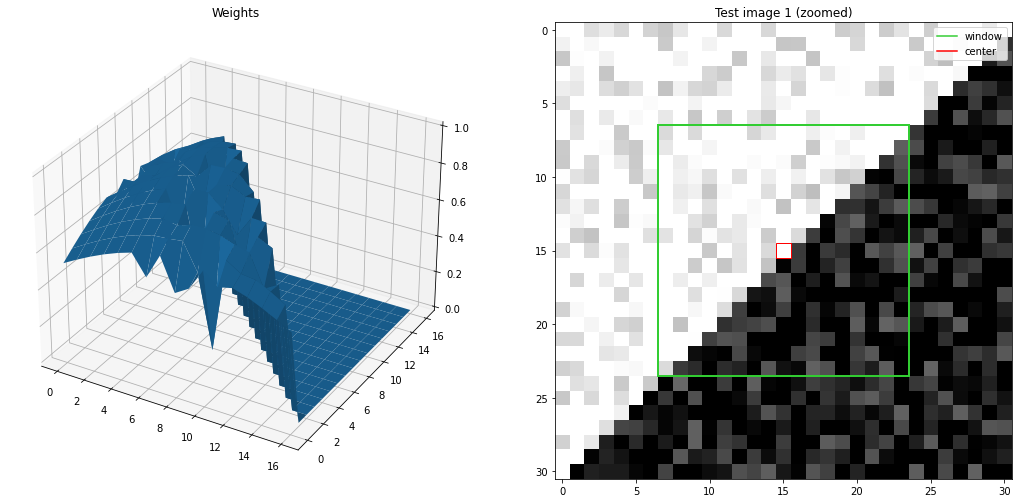

In [6]:
img = test_1
height = img.shape[1]
length = img.shape[0]

x = y = int(img.shape[1]/2)
window_size = 17
half_ws= int(window_size/2)

sigma_d = 10
sigma_r = 8

w_matrix = np.zeros((window_size, window_size))
C_matrix = np.zeros((window_size, window_size))
S_matrix = np.zeros((window_size, window_size))

for i in range(window_size):
    for j in range(window_size):
        p_y = y + i - int(window_size/2)
        p_x = x + j - int(window_size/2)

        C = c([p_x, p_y], [x, y], sigma_d)
        S = s(img[p_x, p_y], img[x, y], sigma_r, gray_img=True)
        weight = C * S
        
        w_matrix[j,i] = weight
        C_matrix[j,i] = C
        S_matrix[j,i] = S

# Plot of weights and the image
fig = plt.figure(figsize=(18,10))
surface_plot(w_matrix, "Weights", fig)
ax = fig.add_subplot(122)
ax.set_title("Test image 1 (zoomed)")
zoom_start = 35
zoom_end=length-zoom_start
ax.imshow(test_1n[zoom_start:zoom_end, zoom_start:zoom_end], cmap='gray')
window = patches.Rectangle((x-half_ws-zoom_start-0.5, x-half_ws-zoom_start-0.5), window_size, window_size, linewidth=2, edgecolor='#32CD32', facecolor='none')
center = patches.Rectangle((x-zoom_start-.5, x-zoom_start-.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(window)
ax.add_patch(center)
# Legend
line_1 = Line2D([0], [0], label='center', color='r')
line_2 = Line2D([0], [0], label='window', color='#32CD32')
ax.legend(handles=[line_2, line_1])

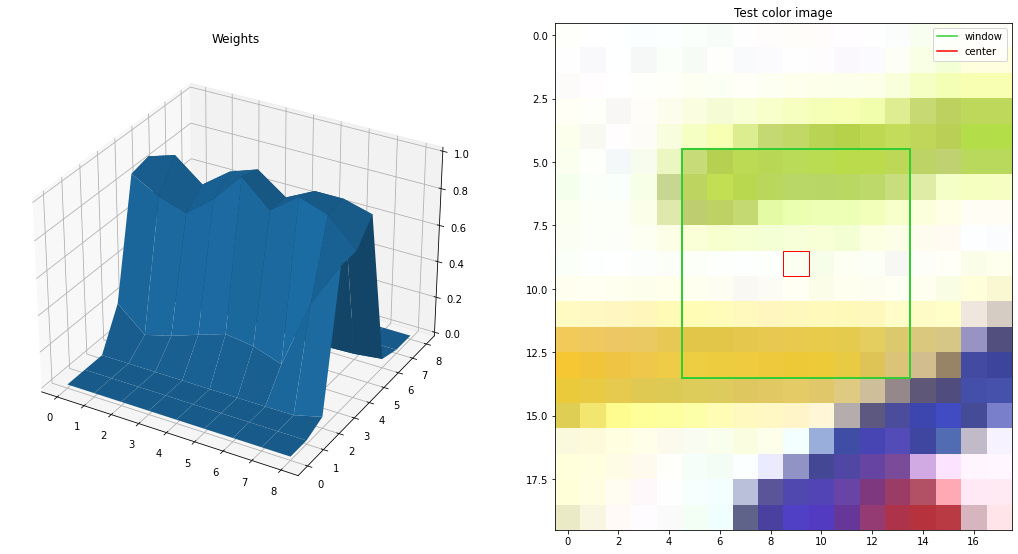

In [7]:
image_path = r'C:\Users\carot\Downloads\DISIP\pictures\test_4.jpg'
rgb_img, lab_img = load_image(image_path, False)

height = lab_img.shape[1]
length = lab_img.shape[0]

x = y = int(lab_img.shape[1]/2)
window_size = 9
half_ws=int(window_size/2)

sigma_d = 10
sigma_r = 8

C_matrix = np.zeros((window_size, window_size))
S_matrix = np.zeros((window_size, window_size))

for i in range(window_size):
    for j in range(window_size):
        p_y = y + i - int(window_size/2)
        p_x = x + j - int(window_size/2)
        
        C_matrix[j,i] = c([p_x, p_y], [x, y], sigma_d)
        S_matrix[j,i] = s([lab_img[p_x, p_y]], lab_img[x, y], sigma_r, gray_img=False)
        
w_matrix = C_matrix*S_matrix

# Plot of weights and the image
fig = plt.figure(figsize=(18,10))
surface_plot(w_matrix, "Weights", fig)
ax = fig.add_subplot(122)
ax.set_title("Test color image")
ax.imshow(rgb_img)
window = patches.Rectangle((x-half_ws-0.5, x-half_ws-0.5), window_size, window_size, linewidth=2, edgecolor='#32CD32', facecolor='none')
center = patches.Rectangle((x-.5, x-.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(window)
ax.add_patch(center)
# Legend
line_1 = Line2D([0], [0], label='center', color='r')
line_2 = Line2D([0], [0], label='window', color='#32CD32')
ax.legend(handles=[line_2, line_1])

In [4]:
def bilateral_filter(img, sigma_d, sigma_r, window_size=7):
    height = img.shape[1]
    length = img.shape[0]
    half_wsize = int(window_size/2)
    
    is_gray=None
    if (len(img.shape)==3):
        is_gray=False
    elif (len(img.shape)==2):
        is_gray=True
    
    C_matrix = spatial_kernel(window_size, sigma_d)
    filtered_img = np.zeros(img.shape)
    
    for y in range(height):
        y_low  = max(y-half_wsize, 0)
        y_high = min(y+half_wsize+1, height)
        for x in range(length):
            x_low  = max(x-half_wsize, 0)
            x_high = min(x+half_wsize+1, length)
            
            S_matrix = similatiry_matrix(img[x, y], img[x_low:x_high, y_low:y_high], sigma_r, is_gray)
            w_matrix = C_matrix[half_wsize-x+x_low:x_high-x+half_wsize, half_wsize-y+y_low:y_high-y+half_wsize] * \
                        S_matrix
            
            if not is_gray:
                filtered_pixel = (np.sum(img[x_low:x_high, y_low:y_high]*np.stack((w_matrix,w_matrix,w_matrix), axis=2), axis=(0,1)) / np.sum(w_matrix))
            else:
                filtered_pixel = (np.sum(img[x_low:x_high, y_low:y_high]*w_matrix) / np.sum(w_matrix)).astype(int)
            filtered_img[x, y] = filtered_pixel
            
    return filtered_img

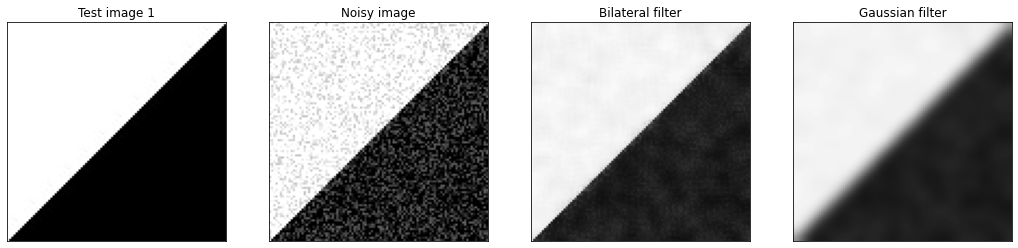

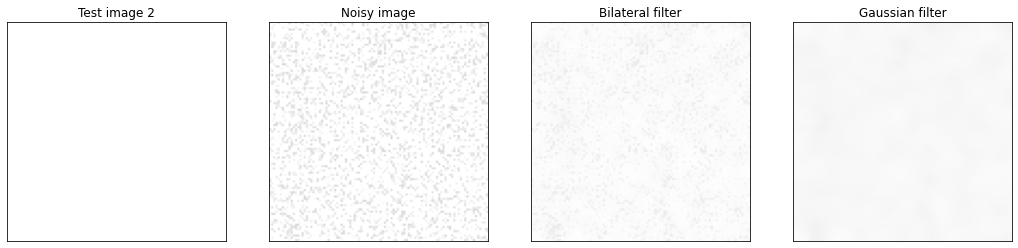

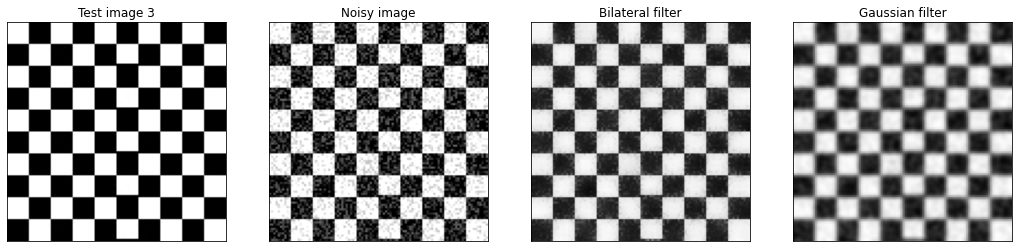

In [9]:
f_img_1 = bilateral_filter(test_1n, sigma_d=10, sigma_r=100, window_size=7)
f_img_2 = bilateral_filter(test_2n, sigma_d=10, sigma_r=20, window_size=7)
f_img_3 = bilateral_filter(test_3n, sigma_d=10, sigma_r=100, window_size=7)

fig_size=(18,14)
compare_image([test_1, test_1n, f_img_1, gaussian_filter(test_1n, 3)],\
              ['Test image 1','Noisy image','Bilateral filter', 'Gaussian filter'], fig_size)
compare_image([test_2, test_2n, f_img_2, gaussian_filter(test_2n, 3)],\
              ['Test image 2','Noisy image','Bilateral filter', 'Gaussian filter'], fig_size)
compare_image([test_3, test_3n, f_img_3, gaussian_filter(test_3n, 1)],\
              ['Test image 3','Noisy image','Bilateral filter', 'Gaussian filter'], fig_size)

# Test with real images
##### Gray image

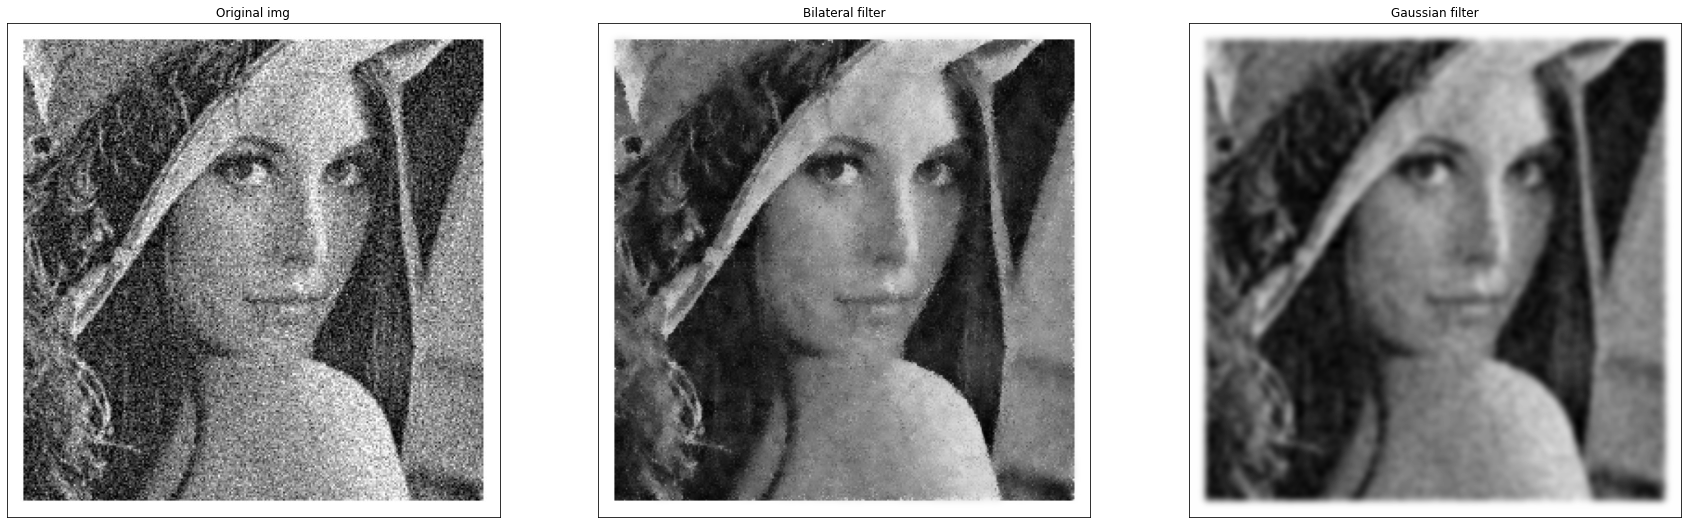

In [10]:
image_path = r'C:\Users\carot\Downloads\DISIP\pictures\lena_noise.jpg'
gray_img = load_image(image_path).astype(int)

f_img = bilateral_filter(gray_img, sigma_d=5, sigma_r=50, window_size=43)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,60))
#Original image
ax1.set_title("Original img")
ax1.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax1.imshow(gray_img, cmap='gray')

#Filtered image - bilateral filter
ax2.set_title("Bilateral filter")
ax2.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax2.imshow(f_img, cmap='gray')

#Filtered image - gaussian filter
ax3.set_title("Gaussian filter")
ax3.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax3.imshow(gaussian_filter(gray_img, 4), cmap='gray')
plt.show()

In [29]:
save_dir = r"C:\Users\carot\Downloads\DISIP\pictures\lena_noise"
image_path = r'C:\Users\carot\Downloads\DISIP\pictures\lena_noise.jpg'
gray_img = load_image(image_path).astype(int)

window_size = 43
sigma_d_list = [5,20,80]
sigma_r_list = [10,50,100,300]

padding = 0
img_collage = np.zeros((gray_img.shape[0]*len(sigma_r_list) + padding*(len(sigma_r_list)+1),
                       gray_img.shape[1]*len(sigma_d_list) + padding*(len(sigma_d_list)+1)))

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for i, sigma_d in enumerate(sigma_d_list):
    print("\n[{}/{}]:{}".format(i+1, len(sigma_d_list),sigma_d), end="\n\t")
    for j, sigma_r in enumerate(sigma_r_list):
        print("[{}/{}]:{}".format(j+1, len(sigma_r_list),sigma_r), end='  |  ')

        f_img = bilateral_filter(gray_img, sigma_d, sigma_r, window_size)
        
        #Save the filtered image
        cv2.imwrite(os.path.join(save_dir, 'img_'+str(sigma_d)+'_'+str(sigma_r)+'.jpg'), f_img)    
        img_collage[j*gray_img.shape[0]+j*padding:(j+1)*gray_img.shape[0]+j*padding,
                    i*gray_img.shape[1]+i*padding:(i+1)*gray_img.shape[1]+i*padding] = f_img

cv2.imwrite(os.path.join(save_dir, 'collage.jpg'), img_collage)


[1/3]:5
	[1/4]:10  |  [2/4]:50  |  [3/4]:100  |  [4/4]:300  |  
[2/3]:20
	[1/4]:10  |  [2/4]:50  |  [3/4]:100  |  [4/4]:300  |  
[3/3]:80
	[1/4]:10  |  [2/4]:50  |  [3/4]:100  |  [4/4]:300  |  

True

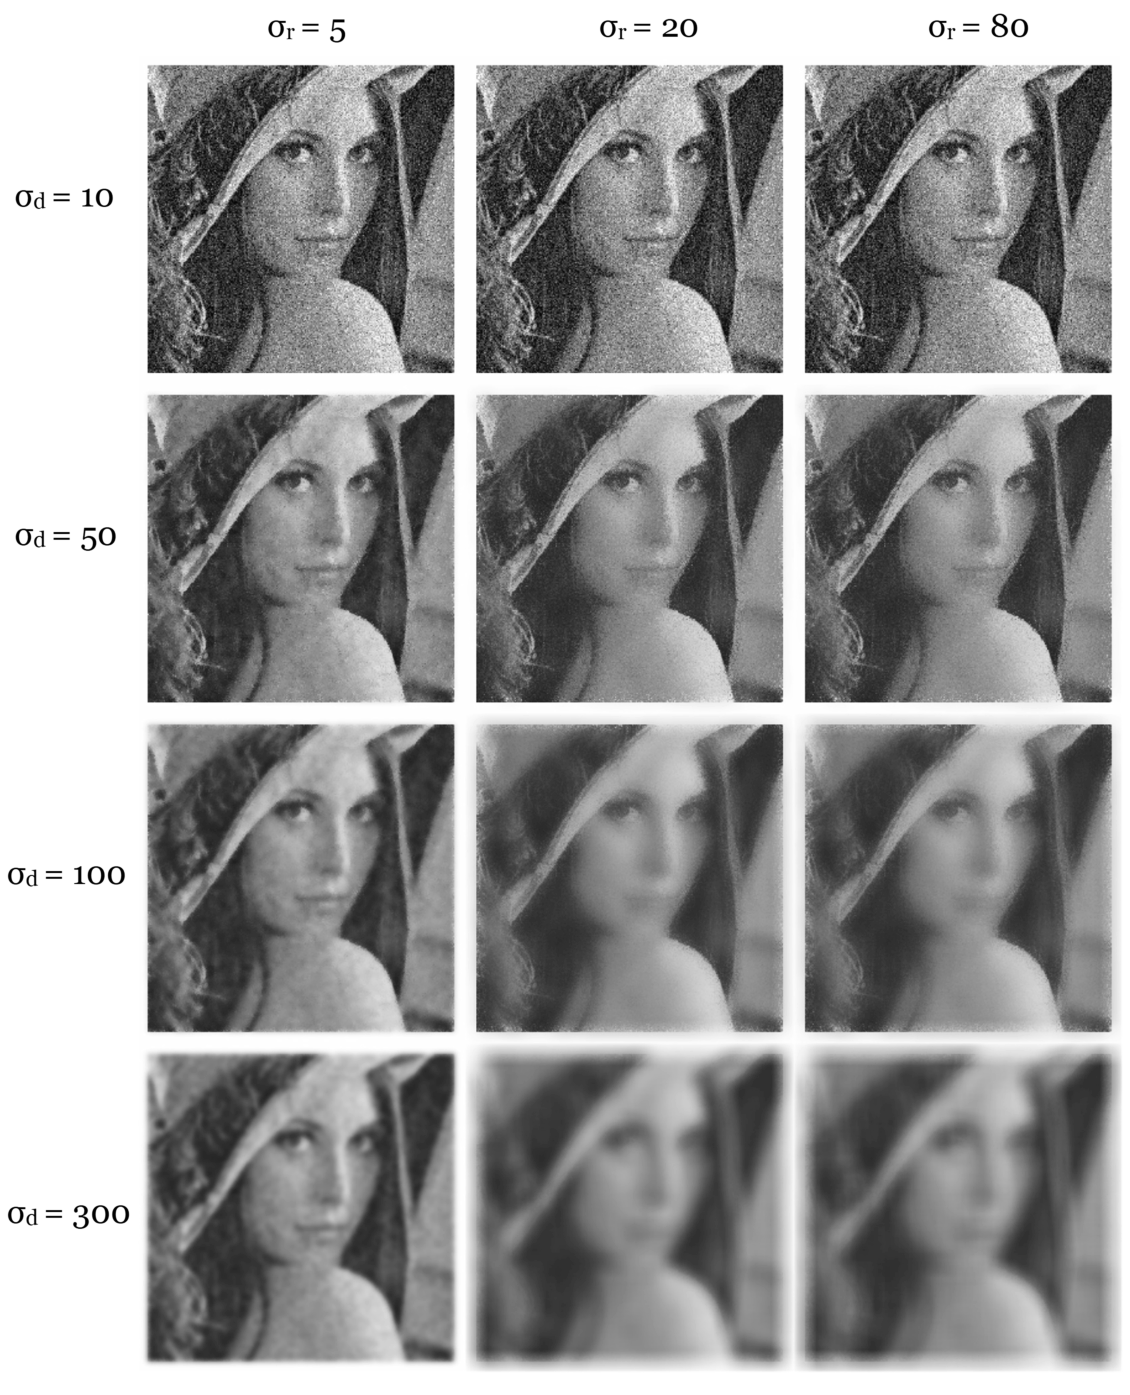

In [34]:
result = load_image(os.path.join(save_dir, 'collage_lable.jpg'))

fig, ax = plt.subplots(figsize=(20,50))
ax.axis('off')
plt.imshow(result, cmap='gray')

### Bilateral Filtering Color Images

Bilateral filters can be applied to color images just as easily as they are applied to gray ones. The CIE-Lab color space gives the space of colors with a perceptually meaningful measure of color similarity, in which short Euclidean distances correlate strongly with human color discrimination performance. Thus, if we use this metric in our bilateral filter, images are smoothed and edges are preserved in a way that is tuned to human performance:    
<ul>
  <li>Only perceptually similar colors are averaged together</li>
  <li>only perceptually visible edges are preserved</li>
</ul> 

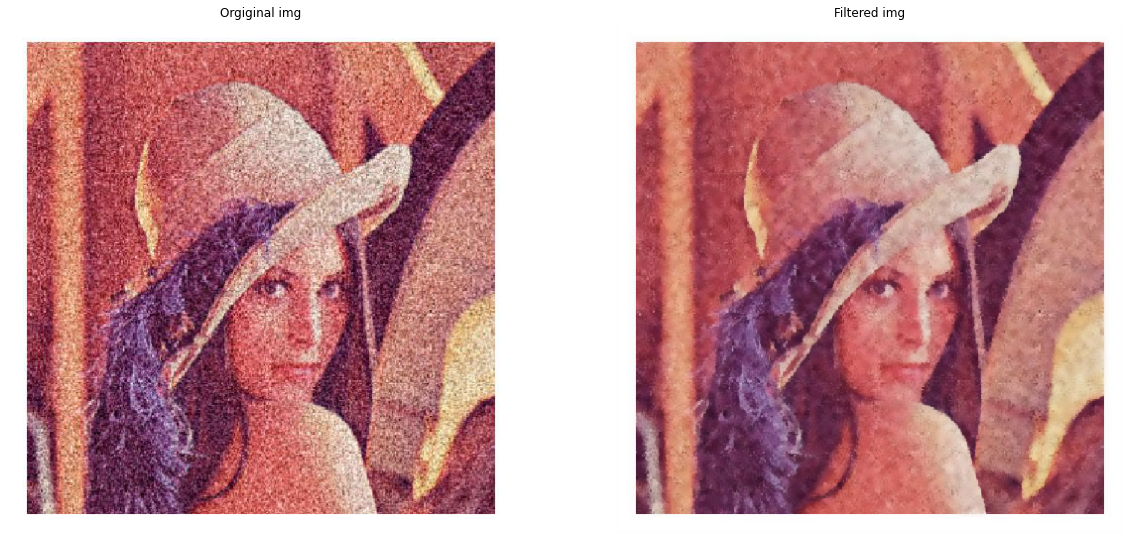

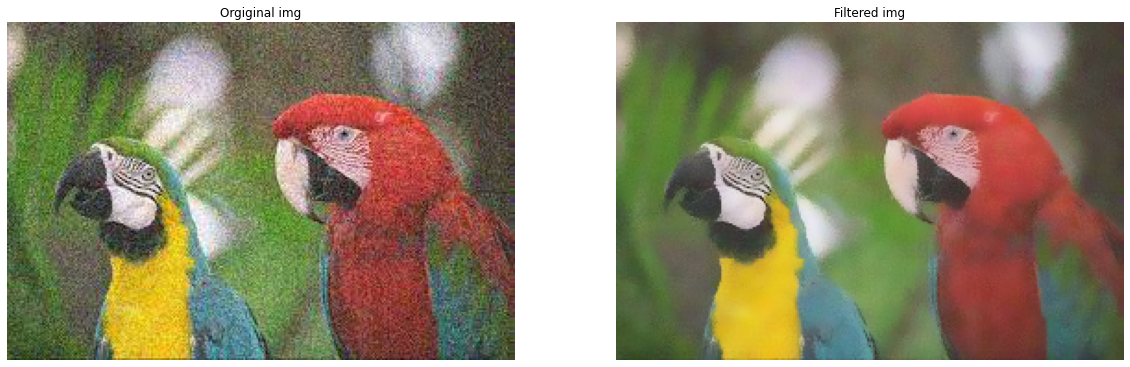

In [28]:
lena_c_path = r'C:\Users\carot\Downloads\DISIP\pictures\lena_noise_color.jpg'
parrots_path = r'C:\Users\carot\Downloads\DISIP\pictures\parrots.jpg'
rgb_img1, lab_img1 = load_image(lena_c_path, False)
rgb_img2, lab_img2 = load_image(parrots_path, False)

f_img1_lab = bilateral_filter(lab_img1, sigma_d=5, sigma_r=15, window_size=9)
f_img2_lab = bilateral_filter(lab_img2, sigma_d=5, sigma_r=15, window_size=9)
    
# Lena
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,12))
ax1.set_title("Orgiginal img")
ax1.imshow(rgb_img1)
ax1.axis('off')
ax2.set_title("Filtered img")
ax2.imshow((color.lab2rgb(f_img1_lab)*255).astype(np.uint8))
ax2.axis('off')

# Parrots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,12))
ax1.set_title("Orgiginal img")
ax1.imshow(rgb_img2)
ax1.axis('off')
ax2.set_title("Filtered img")
ax2.imshow((color.lab2rgb(f_img2_lab)*255).astype(np.uint8))
ax2.axis('off')

In [ ]:
# 2% of the diagonal

In [17]:
save_dir = r"C:\Users\carot\Downloads\DISIP\pictures\lena_noise_color"
image_path = r'C:\Users\carot\Downloads\DISIP\pictures\lena_noise_color.jpg'

rgb_img, lab_img = load_image(image_path, False)
sigma_d_list = [0.5,1,5,20,80,150]
sigma_r_list = [1,10,50,100,300,500]

padding = 0
window_size=43
img_collage = np.zeros((rgb_img.shape[0]*len(sigma_r_list) + padding*(len(sigma_r_list)+1),
                       rgb_img.shape[1]*len(sigma_d_list) + padding*(len(sigma_d_list)+1),3))

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for i, sigma_d in enumerate(sigma_d_list):
    print("\n[{}/{}]:{}".format(i+1, len(sigma_d_list),sigma_d), end="\n\t")
    for j, sigma_r in enumerate(sigma_r_list):
        print("[{}/{}]:{}".format(j+1, len(sigma_r_list),sigma_r), end='  |  ')

        f_img_lab = bilateral_filter(lab_img, sigma_d, sigma_r, window_size)
        f_img_rgb = (color.lab2rgb(f_img_lab)*255).astype(np.uint8)
        
        #Save the filtered image
        cv2.imwrite(os.path.join(save_dir, 'img_'+str(sigma_d)+'_'+str(sigma_r)+'.jpg'), cv2.cvtColor(f_img_rgb, cv2.COLOR_BGR2RGB))    
        img_collage[j*rgb_img.shape[0]+j*padding:(j+1)*rgb_img.shape[0]+j*padding,
                    i*rgb_img.shape[1]+i*padding:(i+1)*rgb_img.shape[1]+i*padding,:] = cv2.cvtColor(f_img_rgb, cv2.COLOR_BGR2RGB)

cv2.imwrite(os.path.join(save_dir, 'collage.jpg'), img_collage)


[1/6]:0.5
	[1/6]:1  |  [2/6]:10  |  [3/6]:50  |  [4/6]:100  |  [5/6]:300  |  [6/6]:500  |  
[2/6]:1
	[1/6]:1  |  [2/6]:10  |  [3/6]:50  |  [4/6]:100  |  [5/6]:300  |  [6/6]:500  |  
[3/6]:5
	[1/6]:1  |  [2/6]:10  |  [3/6]:50  |  [4/6]:100  |  [5/6]:300  |  [6/6]:500  |  
[4/6]:20
	[1/6]:1  |  [2/6]:10  |  [3/6]:50  |  [4/6]:100  |  [5/6]:300  |  [6/6]:500  |  
[5/6]:80
	[1/6]:1  |  [2/6]:10  |  [3/6]:50  |  [4/6]:100  |  [5/6]:300  |  [6/6]:500  |  
[6/6]:150
	[1/6]:1  |  [2/6]:10  |  [3/6]:50  |  [4/6]:100  |  [5/6]:300  |  [6/6]:500  |  

True

### Iterating the Bilateral Filter

While a single iteration produces a much cleaner image than the original, and is probably sufficient
for most image processing needs, <b>multiple iterations have the effect of flattening the colors</b> in an image considerably, <b>without blurring edges</b>. The resulting image has a much smaller color map, and the effects of bilateral filtering are easier to see when displayed on a printed page. Notice the cartoon-like appearance . All shadows and edges are preserved, but most of the shading is gone, and no “new” colors are introduced by filtering

A single iteration produces a cleaner image than the original, and preserves edges even when a very wide Gaussian is used for the domain component. Multiple iterations are still useful in some circumstances, but only when a cartoon-like image is desired as the output.

In [8]:
def itarate_bilateralFilter(path, image_name, iteration_n=5, w_size=43, s_d=5, s_r=10):
    save_dir = os.path.join(path, image_name[:-4]+"_it")
    image_path = os.path.join(path, image_name)

    rgb_img, lab_img = load_image(image_path, False)
    f_images = []
    f_img_lab = lab_img

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
        
    for i in range(iteration_n):
        print(i, end=', ')
        f_img_lab = bilateral_filter(f_img_lab, sigma_d=s_d, sigma_r=s_r, window_size=w_size)
        f_img_rgb = (color.lab2rgb(f_img_lab)*255).astype(np.uint8)
        f_images.append(f_img_lab)
        
        cv2.imwrite(os.path.join(save_dir, 'paine_'+str(i)+'.jpg'), cv2.cvtColor(f_img_rgb, cv2.COLOR_BGR2RGB))
    
    return f_images

In [ ]:
main_path = r"C:\Users\carot\Downloads\DISIP\pictures"
image_name = 'paine.jpg'
iteration_number = 10
#itarate_bilateralFilter(main_path, image_name, iteration_number)


itarate_bilateralFilter(main_path,'silvia_neve.jpg',6)
print()

---

### Conlusion:
<center><b>Conclusion</b></center>
